In [56]:
import qiskit
from qiskit.circuit import QuantumCircuit
from qiskit.providers.aer.noise import NoiseModel
from qiskit_aer import AerSimulator
import numpy as np
import pandas as pd
from mitiq import Executor, MeasurementResult, Observable
from cirq import DensityMatrixSimulator, depolarize
from mitiq.interface import convert_to_mitiq
import mitiq
from mitiq import zne, benchmarks, pec
from mitiq.pec.representations.depolarizing import represent_operations_in_circuit_with_local_depolarizing_noise

import qiskit
from qiskit.circuit import QuantumCircuit
from qiskit.providers.aer.noise import NoiseModel
from qiskit_aer import AerSimulator
import numpy as np
import pandas as pd
from mitiq import Executor, MeasurementResult, Observable
from cirq import DensityMatrixSimulator, depolarize
from mitiq.interface import convert_to_mitiq
import mitiq
from mitiq import zne, benchmarks, pec
from mitiq.pec.representations import find_optimal_representation
from mitiq.pec.representations.depolarizing import represent_operations_in_circuit_with_local_depolarizing_noise
from mitiq.pec.channels import kraus_to_super
from qiskit.circuit.library import RZGate, SXGate, CXGate
from qiskit.circuit.library.generalized_gates import PauliGate
from qiskit.extensions import UnitaryGate
import time
import copy
import pdb
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit_experiments.library import LocalReadoutError, CorrelatedReadoutError
from qiskit.tools.visualization import *
from qiskit_aer import AerSimulator
from qiskit.providers.fake_provider import FakePerth

from qiskit.result.mitigation.utils import (
    expval_with_stddev,
    str2diag,
    counts_probability_vector
)

# Import general libraries (needed for functions)
import numpy as np
import time

# Import Qiskit classes
import qiskit
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, Aer
from qiskit.providers.aer import noise
from qiskit.tools.visualization import plot_histogram

# Import measurement calibration functions
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)



In [4]:
noise_dict = pd.read_pickle('./NoiseModel/fakecairo.pkl')
# Load the noise model from the dictionary
noise_model = NoiseModel.from_dict(noise_dict)
backend = AerSimulator(method = "density_matrix", noise_model = noise_model)

/tmp/ipykernel_194810/3179522997.py:3: DeprecationWarning: from_dict has been deprecated as of qiskit-aer 0.10.0 and will be removed no earlier than 3 months from that release date.
  noise_model = NoiseModel.from_dict(noise_dict)


In [5]:
shots = 1024
qubits = [0,1,2,3]
num_qubits = len(qubits)

exp = LocalReadoutError(qubits)
for c in exp.circuits():
    print(c)

         ░ ┌─┐         
   q_0: ─░─┤M├─────────
         ░ └╥┘┌─┐      
   q_1: ─░──╫─┤M├──────
         ░  ║ └╥┘┌─┐   
   q_2: ─░──╫──╫─┤M├───
         ░  ║  ║ └╥┘┌─┐
   q_3: ─░──╫──╫──╫─┤M├
         ░  ║  ║  ║ └╥┘
meas: 4/════╩══╩══╩══╩═
            0  1  2  3 
        ┌───┐ ░ ┌─┐         
   q_0: ┤ X ├─░─┤M├─────────
        ├───┤ ░ └╥┘┌─┐      
   q_1: ┤ X ├─░──╫─┤M├──────
        ├───┤ ░  ║ └╥┘┌─┐   
   q_2: ┤ X ├─░──╫──╫─┤M├───
        ├───┤ ░  ║  ║ └╥┘┌─┐
   q_3: ┤ X ├─░──╫──╫──╫─┤M├
        └───┘ ░  ║  ║  ║ └╥┘
meas: 4/═════════╩══╩══╩══╩═
                 0  1  2  3 


In [8]:
exp.analysis.set_options(plot=True)
result = exp.run(backend)
# mitigator = result.analysis_results(0).value

AttributeError: 'tuple' object has no attribute 'configuration'

In [9]:
from cirq import LineQubit, Circuit, X, measure_each

from mitiq.observable.observable import Observable
from mitiq.observable.pauli import PauliString

qreg = [LineQubit(i) for i in range(2)]
circuit = Circuit(X.on_each(*qreg))
observable = Observable(PauliString("ZI"), PauliString("IZ"))

print(circuit)

0: ───X───

1: ───X───


In [ ]:
from functools import partial

import numpy as np
from cirq.experiments.single_qubit_readout_calibration_test import (
    NoisySingleQubitReadoutSampler,
)

from mitiq import MeasurementResult

def noisy_readout_executor(circuit, p0, p1, shots=8192) -> MeasurementResult:
    # Replace with code based on your frontend and backend.
    simulator = NoisySingleQubitReadoutSampler(p0, p1)
    result = simulator.run(circuit, repetitions=shots)
    bitstrings = np.column_stack(list(result.measurements.values()))
    return MeasurementResult(bitstrings, qubit_indices = (0, 1))

In [ ]:
from mitiq.raw import execute as raw_execute

# Compute the expectation value of the observable.
# Use a noisy executor that has a 25% chance of bit flipping
p_flip = 0.25
noisy_executor = partial(noisy_readout_executor, p0=p_flip, p1=p_flip)
noisy_value = raw_execute(circuit, noisy_executor, observable)

ideal_executor = partial(noisy_readout_executor, p0=0, p1=0)
ideal_value = raw_execute(circuit, ideal_executor, observable)
error = abs((ideal_value - noisy_value)/ideal_value)
print(f"Error without mitigation: {error:.3}")

In [69]:
qr = qiskit.QuantumRegister(5)
cr = ClassicalRegister(3)
ghz = QuantumCircuit(qr, cr)
ghz.h(qr[2])
ghz.cx(qr[2], qr[3])
ghz.cx(qr[3], qr[4])
ghz.measure(qr[2],cr[0])
ghz.measure(qr[3],cr[1])
ghz.measure(qr[4],cr[2])
qubit_list = [[0],[1],[2],[3],[4]]
cal_circuits, mit_pattern = tensored_meas_cal(mit_pattern=qubit_list, qr=qr, circlabel='mcal')
# meas_calibs, state_labels = complete_meas_cal(qubit_list=qubit_list, qr=qr, circlabel='mcal')
cal_circuits[0].draw()

░ ┌─┐            
q23_0: ─░─┤M├────────────
        ░ └╥┘┌─┐         
q23_1: ─░──╫─┤M├─────────
        ░  ║ └╥┘┌─┐      
q23_2: ─░──╫──╫─┤M├──────
        ░  ║  ║ └╥┘┌─┐   
q23_3: ─░──╫──╫──╫─┤M├───
        ░  ║  ║  ║ └╥┘┌─┐
q23_4: ─░──╫──╫──╫──╫─┤M├
        ░  ║  ║  ║  ║ └╥┘
c22: 5/════╩══╩══╩══╩══╩═
           0  1  2  3  4

In [76]:
noise_dict = pd.read_pickle('./NoiseModel/fakecairo.pkl')
# Load the noise model from the dictionary
noise_model = NoiseModel.from_dict(noise_dict)

backend = qiskit.Aer.get_backend('qasm_simulator')
job = qiskit.execute(cal_circuits, backend=backend, shots=10000, noise_model=noise_model)
cal_results = job.result()
meas_fitter = TensoredMeasFitter(cal_results, mit_pattern, circlabel='mcal')
# Results without mitigation
raw_counts = cal_results.get_counts()

# Get the filter object
meas_filter = meas_fitter.filter

# Results with mitigation
mitigated_results = meas_filter.apply(cal_results)
mitigated_counts = mitigated_results.get_counts()

print(meas_fitter.cal_matrices)

/tmp/ipykernel_22673/1110123049.py:3: DeprecationWarning: from_dict has been deprecated as of qiskit-aer 0.10.0 and will be removed no earlier than 3 months from that release date.
  noise_model = NoiseModel.from_dict(noise_dict)


method: SLSQPmethod: SLSQP

[array([[0.9933, 0.0095],
       [0.0067, 0.9905]]), array([[0.9957, 0.0097],
       [0.0043, 0.9903]]), array([[0.9938, 0.0095],
       [0.0062, 0.9905]]), array([[0.9933, 0.008 ],
       [0.0067, 0.992 ]]), array([[0.9909, 0.0145],
       [0.0091, 0.9855]])]


In [74]:
raw_counts

[{'10001': 1,
  '10010': 1,
  '00001': 30,
  '01001': 1,
  '01000': 30,
  '00100': 26,
  '10000': 35,
  '00010': 23,
  '00000': 4853},
 {'10011': 1,
  '01110': 1,
  '10111': 35,
  '11011': 46,
  '11110': 47,
  '11100': 1,
  '10110': 1,
  '01111': 88,
  '01011': 2,
  '11101': 51,
  '11111': 4727}]

In [75]:
mitigated_counts
# plot_histogram([raw_counts, mitigated_counts], legend=['raw', 'mitigated'])

[{'00000': 5000.0, '10000': 8.517629632165402e-08},
 {'00001': 4.510117155556008e-15,
  '00010': 6.629457111045806e-16,
  '00011': 7.808725839461804e-16,
  '00100': 3.1530902776900923e-16,
  '00110': 8.977968699039407e-16,
  '01000': 7.585119021653011e-16,
  '01001': 3.7540687227735455e-16,
  '01010': 8.262520013303863e-16,
  '01011': 0.3364112043239343,
  '01100': 7.005660247462654e-16,
  '01110': 1.2679063422907657e-15,
  '01111': 4.148951962498738e-15,
  '10001': 1.0178263192223816e-15,
  '10010': 2.6381605131665573e-17,
  '10011': 5.4359402842778464e-15,
  '10100': 3.42735763856575e-16,
  '10110': 5.882509299992192e-15,
  '11100': 4.11585535595694e-15,
  '11101': 0.5277373562054327,
  '11111': 4999.135851439471}]

In [44]:
a = np.array([[0.9918, 0.0126],
       [0.0082, 0.9874]])
b = np.array([[0.9932, 0.0068], [0.010199999999999987, 0.9898]])
c = a @ b
d = np.linalg.inv(b)
meas_fitter.cal_matrices[0] = d
print(c)
print(d)
print(d @ b)
print(meas_fitter.cal_matrices)

[[0.98518428 0.01921572]
 [0.01821572 0.97738428]]
[[ 1.0069176 -0.0069176]
 [-0.0103764  1.0103764]]
[[ 1.00000000e+00  1.56092501e-19]
 [-1.48254360e-18  1.00000000e+00]]
[array([[ 1.0069176, -0.0069176],
       [-0.0103764,  1.0103764]]), array([[0.9956, 0.0102],
       [0.0044, 0.9898]]), array([[0.9956, 0.0092],
       [0.0044, 0.9908]]), array([[0.9958, 0.0082],
       [0.0042, 0.9918]]), array([[0.9906, 0.0154],
       [0.0094, 0.9846]]), array([[0.9902, 0.0104],
       [0.0098, 0.9896]]), array([[0.9934, 0.0124],
       [0.0066, 0.9876]])]


In [36]:
meas_fitter

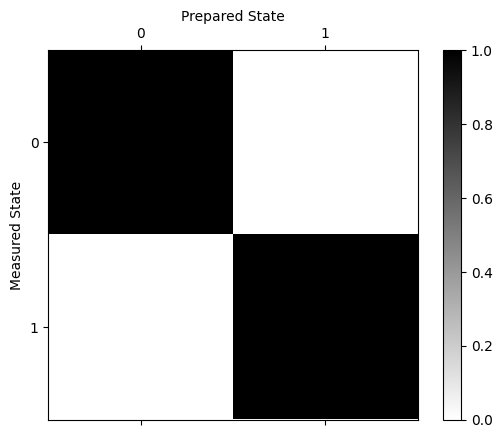

In [45]:
# Plot the calibration matrix
meas_fitter.plot_calibration()

In [50]:
# What is the measurement fidelity?
print("Average Measurement Fidelity: %f" % meas_fitter.readout_fidelity(cal_index=0))

# # What is the measurement fidelity of Q0?
# print("Average Measurement Fidelity of Q0: %f" % meas_fitter.readout_fidelity(
#     label_list = [['000','001','010','011'],['100','101','110','111']]))

Average Measurement Fidelity: 1.008647
